### Fridge power draw analysis

A fridge is a large thermoregulation device for chilling a sealed volume of materials.  It operates by a motorized compressor and a thermostat that triggers the motor to turn on at an upper temperature and stays on until the thermostat registers a lower temperature.

Generally, the motor takes the same amount of time to quickly chill the thermal mass of the cooling system from the upper temperature to the lower temperature, and it takes a variable amount of time for the heat energy to redistribute itself and leak in from the outside.


In [10]:
# Load in the last two days of fridge power use
import influxdb
client = influxdb.DataFrameClient("10.0.30.194", 8086, "root", "root", "balena-sense")

k = client.query("select * from fridgepower order by time desc limit %d" % (2*24*3600))
ig = k["fridgepower"].value  # the series
ig.index[-1] - ig.index[0]

Timedelta('2 days 00:04:04.355402')

In [80]:
from matplotlib import pyplot as plt
from ipywidgets import widgets
%matplotlib inline

vs = ig.values
# single case one from vs
timerange = widgets.IntRangeSlider(value=(0, len(vs)), min=0, max=len(vs), continuous_update=False)
timerange.layout.width = "600px"
ui = widgets.HBox([timerange])

def plotfigure(timerange):
    plt.figure(figsize=(17,6))
    
    s = vs[timerange[0]:timerange[1]]
    plt.plot(s, lw=1)
    if len(s) < 1000:
        plt.scatter(range(len(s)), s)
    plt.xlabel("seconds")
    plt.ylabel("watts")
    plt.title("fridge power")
    plt.show()
    
params = {'timerange': timerange }
outputfigure = widgets.interactive_output(plotfigure, params)
outputfigure.layout.height = '400px'
display(ui, outputfigure);


Output(layout=Layout(height='400px'))

In [13]:
# Find the best value to cut this sequence at
import numpy

s = ig.values.copy()
s.sort()

sqsumcutforward = (s[:-1]**2).cumsum() - s[:-1].cumsum()**2/numpy.arange(1, len(s))
sqsumcutbackward = ((s[:0:-1]**2).cumsum() - s[:0:-1].cumsum()**2/numpy.arange(1, len(s)))[::-1]

#Dsqsumcutforward = numpy.array([ s[:i].var()*i  for i in range(1, len(s)) ])
#Dsqsumcutbackward = numpy.array([ s[i:].var()*(len(s)-i)  for i in range(1, len(s)) ])

icut, var = min(enumerate(sqsumcutforward+sqsumcutbackward), key=lambda X:X[1])
cutvalue = (s[icut] + s[icut+1])/2
icut, s[icut], s[icut+1], cutvalue


(104248, 17, 94, 55.5)

In [50]:
upelements.index.to_series?

In [81]:
from matplotlib import pyplot as plt
%matplotlib inline

import pandas
upelements = ig[(ig.shift()<cutvalue) & (ig>=cutvalue)]
downelements = ig[(ig.shift()>=cutvalue) & (ig<cutvalue)]

updowns = pandas.DataFrame(data={"uptime":upelements.index.to_series(keep_tz=True), 
                                 "downtime":downelements.index.to_series(keep_tz=True)})
updowns.downtime = updowns.downtime.shift(-1)
updowns["uptimeN"] = updowns.uptime.shift(-2)
updowns = updowns.dropna()
updowns["upduration"] = (updowns.downtime - updowns.uptime)/pandas.Timedelta(seconds=1)
updowns["downduration"] = (updowns.uptimeN - updowns.downtime)/pandas.Timedelta(seconds=1)
updowns.head()

,uptime,downtime,uptimeN,upduration,downduration
2019-04-27 16:31:09.903021055+00:00,2019-04-27 16:31:09.903021055+00:00,2019-04-27 16:41:35.653018873+00:00,2019-04-27 16:57:50.787434271+00:00,625.749998,975.134415
2019-04-27 16:57:50.787434271+00:00,2019-04-27 16:57:50.787434271+00:00,2019-04-27 17:08:07.551347830+00:00,2019-04-27 17:24:43.678367219+00:00,616.763914,996.127019
2019-04-27 17:24:43.678367219+00:00,2019-04-27 17:24:43.678367219+00:00,2019-04-27 17:35:05.407424210+00:00,2019-04-27 17:51:16.547804776+00:00,621.729057,971.140381
2019-04-27 17:51:16.547804776+00:00,2019-04-27 17:51:16.547804776+00:00,2019-04-27 18:01:46.296132177+00:00,2019-04-27 18:17:56.442461775+00:00,629.748327,970.146330
2019-04-27 18:17:56.442461775+00:00,2019-04-27 18:17:56.442461775+00:00,2019-04-27 18:28:10.176248119+00:00,2019-04-27 18:44:39.335188531+00:00,613.733786,989.158940


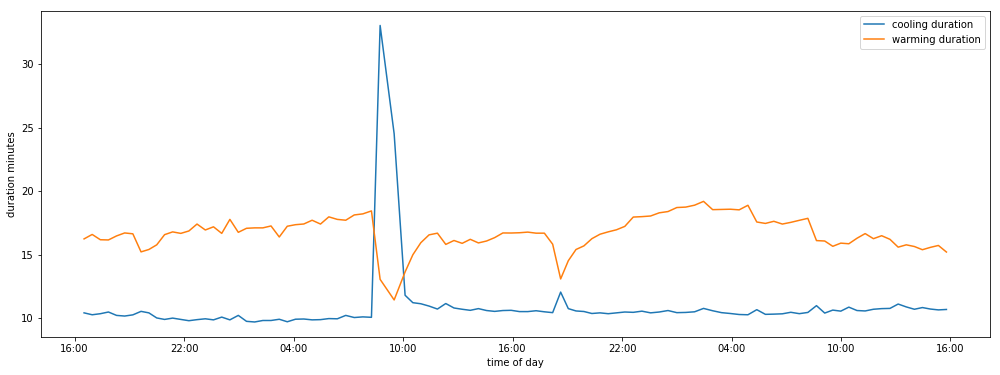

In [90]:
import matplotlib.dates as dates
plt.figure(figsize=(17,6))
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))  # hours and minutes
plt.plot(updowns.upduration/60, label="cooling duration")
plt.plot(updowns.downduration/60, label="warming duration")
plt.xlabel("time of day")
plt.ylabel("duration minutes")
plt.legend();
